# Baseline Random Forest Regression Model

**Gathering Data**

In [1]:
# Add all imports related to data engineering
import json
import numpy as np
import pandas as pd
import string

In [2]:
# Import the training json file, then close the file
file = open("../raw_data/train.json")
raw_data = json.load(file)
file.close()

In [3]:
pii_number_encoding = {
    'B-EMAIL': 0, 
    'B-ID_NUM': 1, 
    'B-NAME_STUDENT': 2, 
    'B-PHONE_NUM': 3, 
    'B-STREET_ADDRESS': 4, 
    'B-URL_PERSONAL': 5, 
    'B-USERNAME': 6, 
    'I-NAME_STUDENT': 7,  
    'I-PHONE_NUM': 8, 
    'I-STREET_ADDRESS': 9,  
    'I-URL_PERSONAL': 10, 
    'O': 11
}

In [4]:
# Got the txt file from here: https://gist.github.com/deekayen/4148741

# Common words List to hold common words
with open("../ml-data-input/most-common-words.txt", "r") as common_words_file:
    common_tokens = [word[:-1] for word in list(common_words_file)]
    common_tokens.append("\n\n")
    common_tokens.append("\n")
    common_tokens.append(" ")

# Add punctuation to the list of commonalities
for char in list(string.punctuation):
    common_tokens.append(char)

print(common_tokens)

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I', 'his', 'they', 'be', 'at', 'one', 'have', 'this', 'from', 'or', 'had', 'by', 'not', 'word', 'but', 'what', 'some', 'we', 'can', 'out', 'other', 'were', 'all', 'there', 'when', 'up', 'use', 'your', 'how', 'said', 'an', 'each', 'she', 'which', 'do', 'their', 'time', 'if', 'will', 'way', 'about', 'many', 'then', 'them', 'write', 'would', 'like', 'so', 'these', 'her', 'long', 'make', 'thing', 'see', 'him', 'two', 'has', 'look', 'more', 'day', 'could', 'go', 'come', 'did', 'number', 'sound', 'no', 'most', 'people', 'my', 'over', 'know', 'water', 'than', 'call', 'first', 'who', 'may', 'down', 'side', 'been', 'now', 'find', 'any', 'new', 'work', 'part', 'take', 'get', 'place', 'made', 'live', 'where', 'after', 'back', 'little', 'only', 'round', 'man', 'year', 'came', 'show', 'every', 'good', 'me', 'give', 'our', 'under', 'name', 'very', 'through', 'just', 'form', 'sentence', 'g

In [5]:
# A function to get rid of the 1000 most common used words
def common_word_drop(token_list, whitespace_list, label_list, rows):
    for word in common_tokens:
        if word in token_list:
            indices = [i for i, x in enumerate(token_list) if x.lower() == word]
            token_list = [token_list[i] for i in range(len(token_list)) if i not in indices]
            whitespace_list = [whitespace_list[i] for i in range(len(whitespace_list)) if i not in indices]
            label_list = [label_list[i] for i in range(len(label_list)) if i not in indices]
            rows = [rows[i] for i in range(len(rows)) if i not in indices]

    return token_list, whitespace_list, label_list, rows

In [6]:
def get_rows(full_tokens):
    rows = []
    row_num = 1
    for token in full_tokens:
        rows.append(row_num)
        if token == "\n\n" or token == "\n":
            row_num = row_num + 1
    return rows

In [7]:
def pii_data_exists(labels):
    # Loop over and see if a PII data is found, if it is, return True, else False.
    for label in labels:
        if label != 'O':
            return True
    return False

In [8]:
def get_closest_label(labels):

    # Initialize the indexer and for all labels, find the indexes that have PII data
    label_indexes = []
    for i in range(len(labels)):
        if labels[i] != 'O':
            label_indexes.append(i)
    
    # If there is no PII data
    if len(label_indexes) == 0:
        return [-1 for label in labels]
    elif len(label_indexes) == 1:
        # Make the array
        label_range = [-1 for label in labels]
        label_range[label_indexes[0]] = 0
        return label_range
    else:
        # Make the array
        label_range = [-1 for label in labels]

        # Get distance for first PII
        first_index = label_indexes[0]
        first_pii_distance = label_indexes[1] - label_indexes[0]
        label_range[first_index] = first_pii_distance

        # Get distance for last PII
        last_index = label_indexes[-1]
        last_pii_distance = label_indexes[-1] - label_indexes[-2]
        label_range[last_index] = last_pii_distance
        
        # Loop over the second to second last PII and get the distances.
        for idx in range(1, len(label_indexes)-1):

            # For the middle PII data points. Set the previous and next PII
            current_pii = label_indexes[idx]
            previous_pii = label_indexes[idx-1]
            next_pii = label_indexes[idx+1]

            # distances
            prev_dist = current_pii - previous_pii
            next_dist = next_pii - current_pii

            # Append the shortest distance to the current pii data
            label_range[current_pii] = min(prev_dist, next_dist)
        
        # Return the label range.
        return label_range

In [9]:
def engineer_data_for_model(data):

    # Get the first value from the data
    first_doc = data[0]

    # Get rid of common words
    all_rows = get_rows(first_doc['tokens'])
    tokens, white_spaces, labels, rows = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'], all_rows)
    closest_labels = get_closest_label(labels)

    # Create the initial dataframe from the above data
    first_doc_data = {
        "tokens": tokens,
        "trailing_whitespaces": white_spaces,
        "capitalized first char": [True if label[0].isupper() else False for label in tokens],
        "token length": [len(token) for token in tokens],
        "is_numeric": [True if token.isnumeric() else False for token in tokens],
        "PII label": [pii_number_encoding[label] for label in labels],
        "Row": rows,
        "Closest PII data": closest_labels
    }
    raw_df = pd.DataFrame(first_doc_data)

    # Loop till the end of the data
    for document in data[1: len(data) - 1]:

        # Check to see if there exists PII data
        if not pii_data_exists(document['labels']):
            continue
            
        # Get rid of common words
        all_rows = get_rows(document['tokens'])
        tokens, white_spaces, labels, rows = common_word_drop(document['tokens'], document['trailing_whitespace'], document['labels'], all_rows)
        closest_labels = get_closest_label(labels)

        # Collect the data in the same way
        doc_data = {
            "tokens": tokens,
            "trailing_whitespaces": white_spaces,
            "capitalized first char": [True if label[0].isupper() else False for label in tokens],
            "token length": [len(token) for token in tokens],
            "is_numeric": [True if token.isnumeric() else False for token in tokens],
            "PII label": [pii_number_encoding[label] for label in labels],
            "Row": rows,
            "Closest PII data": closest_labels
        }
        df = pd.DataFrame(doc_data)

        # Concatenate all the data into one single dataframe
        raw_df = pd.concat([raw_df, df], ignore_index=True, sort=False)

    # Return the concatenated dataframe
    return raw_df


In [29]:
# Get the training data and get rid of some unneeded number values
data = engineer_data_for_model(raw_data[0:1000])
# data = engineer_data_for_model(raw_data)
data

,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label,Row,Closest PII data
0,Thinking,True,True,8,False,11,1,-1
1,innovation,True,False,10,False,11,1,-1
2,reflexion,False,False,9,False,11,1,-1
3,Avril,True,True,5,False,11,1,-1
4,2021,False,False,4,True,11,1,-1
...,...,...,...,...,...,...,...,...
180026,because,True,False,7,False,11,18,-1
180027,learning,True,False,8,False,11,18,-1
180028,experiences,True,False,11,False,11,18,-1
180029,into,True,False,4,False,11,18,-1


In [11]:
close = data.loc[data["Closest PII data"] >= 0, :]
close

,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label,Row,Closest PII data
5,Nathalie,True,True,8,False,2,1,1
6,Sylla,False,True,5,False,7,1,1
158,Nathalie,True,True,8,False,2,23,1
159,Sylla,False,True,5,False,7,23,1
248,Nathalie,True,True,8,False,2,28,1
...,...,...,...,...,...,...,...,...
179535,Amin,True,True,4,False,7,1,1
179786,Stephanie,True,True,9,False,2,1,1
179787,Gonzalez,False,True,8,False,7,1,1
179957,Stephanie,True,True,9,False,2,12,1


In [12]:
# from sklearn.feature_extraction.text import HashingVectorizer
import pickle
from gensim.models import KeyedVectors

model_path = "../GoogleNews-vectors-negative300.bin.gz"
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True, unicode_errors='ignore')

def get_token_vector(token):
  try:
    return word2vec_model[token]
  except KeyError:
    return np.zeros(word2vec_model.vector_size)


In [13]:
vectorized_data = pd.DataFrame({
  'vectors': data['tokens'].apply(lambda tokens: [get_token_vector(token) for token in tokens])
})

vectorized_data

,vectors
0,"[[-0.2421875, 0.14550781, 0.026855469, 0.00759..."
1,"[[-0.22558594, -0.01953125, 0.09082031, 0.2373..."
2,"[[-0.30078125, 0.18945312, -0.03491211, 0.125,..."
3,"[[-0.10595703, 0.21386719, 0.118652344, -0.031..."
4,"[[0.106933594, -0.10546875, 0.053222656, 0.069..."
...,...
180026,"[[-0.203125, 0.053222656, 0.109375, 0.21777344..."
180027,"[[-0.02722168, 0.23046875, -0.061767578, -0.06..."
180028,"[[-0.06933594, 0.15332031, -0.024902344, 0.172..."
180029,"[[-0.22558594, -0.01953125, 0.09082031, 0.2373..."


In [14]:
def flatten_matrix(matrix):
    return np.ravel(matrix)

flattened_data = vectorized_data["vectors"].apply(flatten_matrix)

flattened_data

0         [-0.2421875, 0.14550781, 0.026855469, 0.007598...
1         [-0.2255859375, -0.01953125, 0.0908203125, 0.2...
2         [-0.30078125, 0.18945312, -0.03491211, 0.125, ...
3         [-0.10595703, 0.21386719, 0.118652344, -0.0314...
4         [0.106933594, -0.10546875, 0.053222656, 0.0698...
                                ...                        
180026    [-0.203125, 0.05322265625, 0.109375, 0.2177734...
180027    [-0.0272216796875, 0.23046875, -0.061767578125...
180028    [-0.06933594, 0.15332031, -0.024902344, 0.1728...
180029    [-0.22558594, -0.01953125, 0.09082031, 0.23730...
180030    [-0.337890625, 0.1982421875, -0.296875, 0.1484...
Name: vectors, Length: 180031, dtype: object

In [15]:
# from itertools import zip_longest

# max_len = max(flattened_data.apply(len))

# padded_sequences = flattened_data.apply(lambda vectors: list(zip_longest(vectors, fillvalue=np.zeros_like(vectors[0]))))

# vectorized_data_padded = pd.DataFrame(padded_sequences.tolist(), columns=[f'feature_{i}' for i in range(max_len)])

# print(vectorized_data_padded)

In [16]:
# Concatenate the flattened features with the labels
final_data = pd.concat([flattened_data, data['PII label']], axis=1)

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [18]:
# Train data
y_train = train_data["PII label"].to_numpy()
x_train = train_data.drop(columns=["tokens", "PII label"])


# Test data
y_test = test_data["PII label"].to_numpy()
x_test = test_data.drop(columns=["tokens", "PII label"])

In [19]:
print(f"Length train_x = {len(x_train)} \n Length train_y = {len(y_train)}")

Length train_x = 126021 
 Length train_y = 126021


In [20]:
print(f"Length test_x = {len(x_test)} \n Length test_y = {len(y_test)}")

Length test_x = 54010 
 Length test_y = 54010


**Random Forest Regressor Model**

In [21]:
# Model Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Tree Visualisation
from sklearn.tree import export_graphviz
import graphviz

In [22]:
# Model Fitting
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier()

In [23]:
# Pred Y
y_pred = rf.predict(x_test)

In [24]:
# Report
report = classification_report(y_test, y_pred, labels=[0, 1, 2, 5, 7, 8])
print(report)

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.94      0.83      0.88        18
           2       0.75      0.89      0.81       267
           5       1.00      0.94      0.97        16
           7       0.82      0.65      0.73       222
           8       0.50      0.50      0.50         2

   micro avg       0.79      0.79      0.79       528
   macro avg       0.77      0.80      0.77       528
weighted avg       0.79      0.79      0.78       528



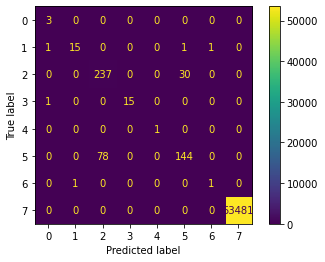

In [25]:
# Generate predictions with the best model
y_pred = rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [26]:
# In order for graphviz to work locally, you'll need to do the following:
# 1. run: `pip install graphviz`
# 2. Download Executable: https://graphviz.org/download/
    #2.1: Install the exe file
    #2.2: Add environment path variable - "C:\Program Files\Graphviz\bin" 

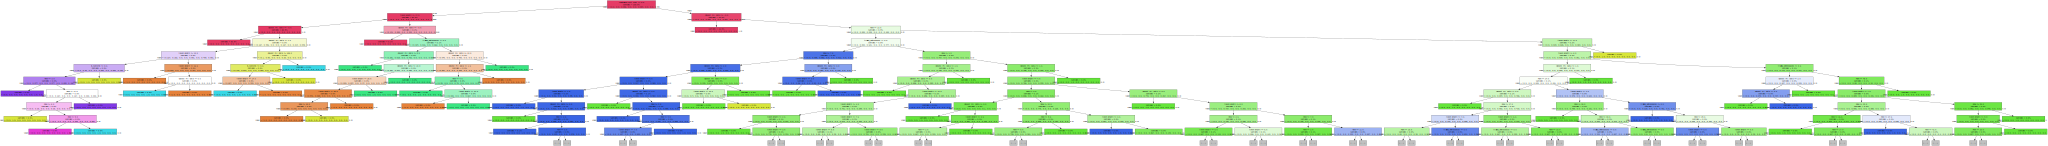

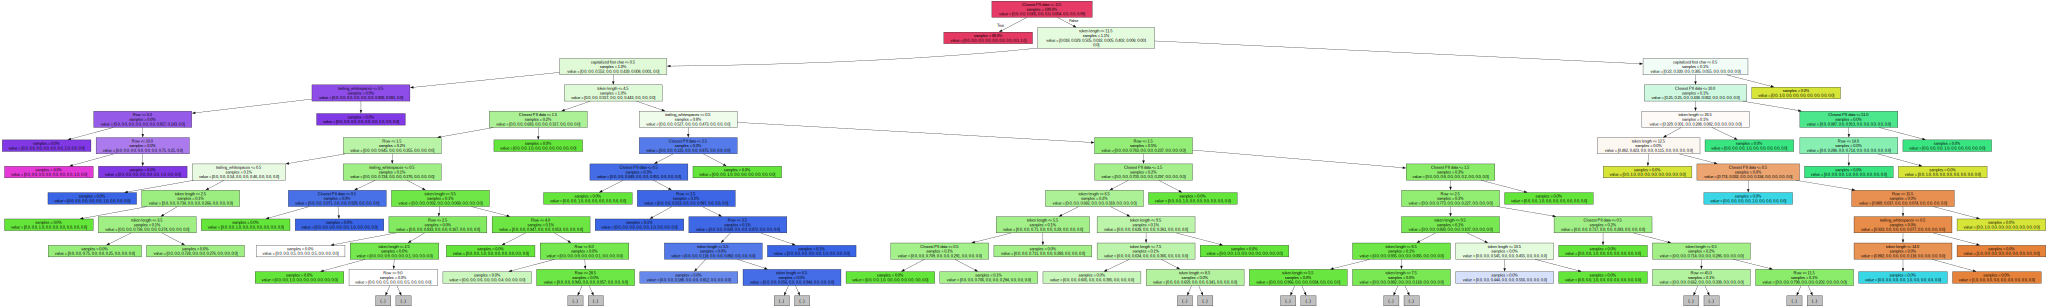

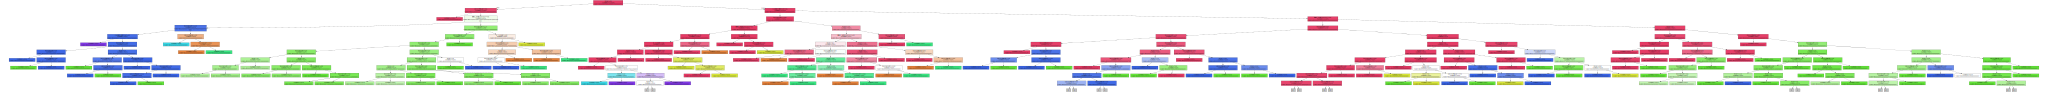

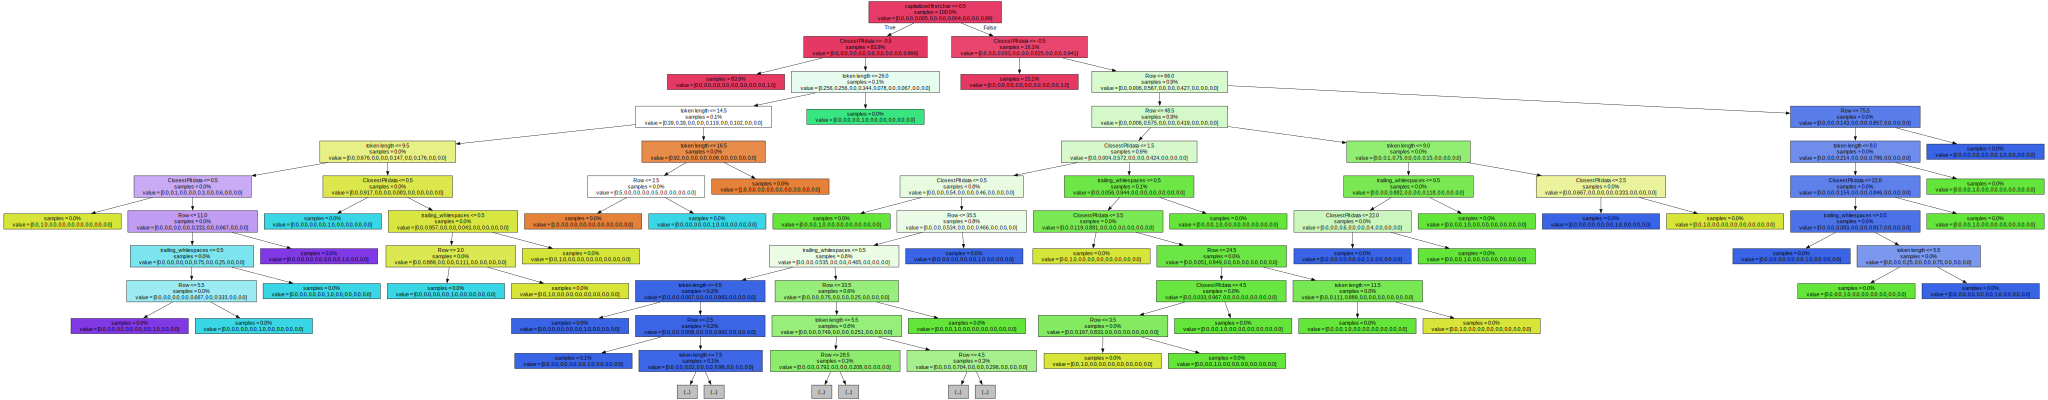

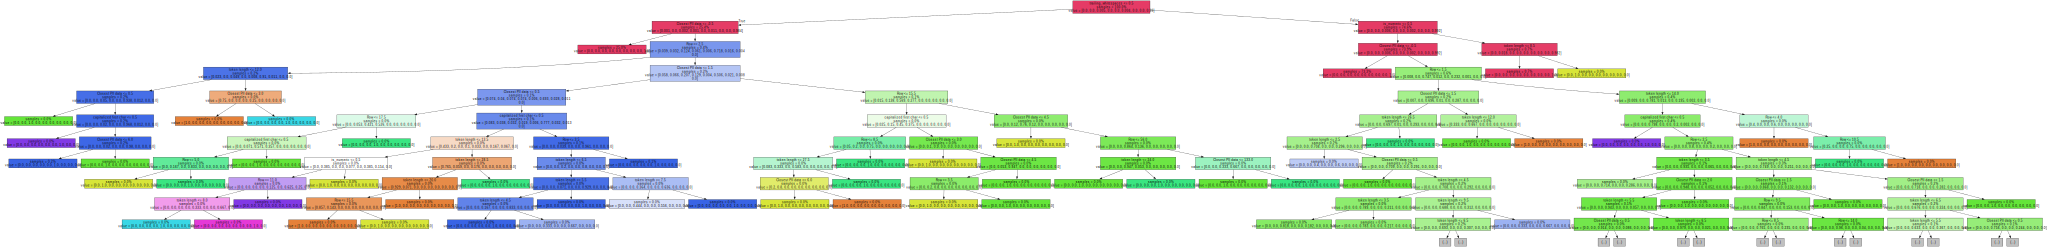

In [27]:
# Creating the Random forest graph for 5 decisions

for i in range(5):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=10, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)